In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from IPython.display import Image, display


In [2]:
def download_stock_data(ticker, start_date, end_date):
    """
    Download daily stock data for the specified ticker and date range.
    Returns a DataFrame with OHLC prices or None if data retrieval fails.
    """
    try:
        stock = yf.Ticker(ticker)
        df = stock.history(start=start_date, end=end_date, interval="1d")
        if df.empty:
            print(f"No data retrieved for {ticker} from {start_date} to {end_date}")
            return None
        return df[['Open', 'High', 'Low', 'Close']]
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")
        return None

def calculate_sma(df, period=30):
    """
    Calculate the Simple Moving Average (SMA) for the specified period.
    Returns the SMA value or None if insufficient data.
    """
    if df is None or len(df) < period:
        print(f"Not enough data for {period}-day SMA. Available: {len(df) if df is not None else 0} days")
        return None
    return df['Close'].rolling(window=period).mean().iloc[-1]

def calculate_pivot_points(df):
    """
    Calculate pivot points and first support/resistance levels based on the most recent day's data.
    Returns a dictionary with PP, R1, and S1 or None if data is invalid.
    """
    if df is None or df.empty:
        print("No data available for pivot point calculation")
        return None
    last_day = df.iloc[-1]
    high = last_day['High']
    low = last_day['Low']
    close = last_day['Close']
    
    pivot_point = (high + low + close) / 3
    r1 = (2 * pivot_point) - low
    s1 = (2 * pivot_point) - high
    
    return {
        'Pivot Point': pivot_point,
        'Resistance R1': r1,
        'Support S1': s1
    }

def calculate_fibonacci_levels(df):
    """
    Calculate Fibonacci retracement levels based on the swing high and low in the data.
    Returns a dictionary with 38.2% and 61.8% retracement levels or None if data is invalid.
    """
    if df is None or df.empty:
        print("No data available for Fibonacci calculation")
        return None
    high = df['High'].max()
    low = df['Low'].min()
    price_range = high - low
    
    fib_38_2 = high - (0.382 * price_range)
    fib_61_8 = high - (0.618 * price_range)
    
    return {
        'Fibonacci 38.2%': fib_38_2,
        'Fibonacci 61.8%': fib_61_8
    }

def plot_support_resistance(df, sma, pivot_levels, fib_levels, window_days):
    """
    Plot TSLA closing prices with support and resistance levels using matplotlib.
    Saves the plot as 'tsla_support_resistance.png' and returns the filename for display.
    """
    if df is None or df.empty:
        print("No data to plot")
        return None
    
    plt.figure(figsize=(12, 6))
    
    # Plot closing prices
    plt.plot(df.index, df['Close'], label='TSLA Closing Price', color='#4CAF50', linewidth=2)
    
    # Plot support and resistance levels if available
    if sma is not None:
        plt.axhline(y=sma, color='#2196F3', linestyle='--', label=f'30-day SMA (${sma:.2f})')
    if pivot_levels is not None:
        plt.axhline(y=pivot_levels['Pivot Point'], color='#FF9800', linestyle='--', label=f'Pivot Point (${pivot_levels["Pivot Point"]:.2f})')
        plt.axhline(y=pivot_levels['Resistance R1'], color='#F44336', linestyle='--', label=f'Resistance R1 (${pivot_levels["Resistance R1"]:.2f})')
        plt.axhline(y=pivot_levels['Support S1'], color='#4CAF50', linestyle='--', label=f'Support S1 (${pivot_levels["Support S1"]:.2f})')
    if fib_levels is not None:
        plt.axhline(y=fib_levels['Fibonacci 38.2%'], color='#9C27B0', linestyle='--', label=f'Fibonacci 38.2% (${fib_levels["Fibonacci 38.2%"]:.2f})')
        plt.axhline(y=fib_levels['Fibonacci 61.8%'], color='#673AB7', linestyle='--', label=f'Fibonacci 61.8% (${fib_levels["Fibonacci 61.8%"]:.2f})')
    
    # Customize plot
    plt.title(f'TSLA Daily Closing Prices with Support and Resistance Levels ({window_days}-Day Window)', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price ($)', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    
    # Adjust y-axis limits
    plt.margins(y=0.1)
    plt.tight_layout()
    
    # Save the plot
    filename = 'tsla_support_resistance.png'
    plt.savefig(filename)
    plt.close()
    return filename


In [3]:
def main(window_days=60):
    """
    Main function to download TSLA data, calculate support/resistance levels, and plot the chart.
    window_days: Number of days for the data window (default 60, can be set to 100).
    """
    # Define date range
    end_date = datetime(2025, 5, 22)
    start_date = end_date - timedelta(days=window_days)
    
    # Download TSLA data
    ticker = "TSLA"
    df = download_stock_data(ticker, start_date, end_date)
    
    if df is None:
        print("Exiting due to data retrieval failure")
        return
    
    # Calculate support and resistance levels
    sma = calculate_sma(df, period=30)
    pivot_levels = calculate_pivot_points(df)
    fib_levels = calculate_fibonacci_levels(df)
    
    # Print results
    print(f"TSLA Support and Resistance Levels (as of {end_date.date()}, {window_days}-Day Window)")
    print(f"Recent Close: ${df['Close'].iloc[-1]:.2f}")
    if sma is not None:
        print(f"30-day SMA: ${sma:.2f}")
    if pivot_levels is not None:
        for key, value in pivot_levels.items():
            print(f"{key}: ${value:.2f}")
    if fib_levels is not None:
        for key, value in fib_levels.items():
            print(f"{key}: ${value:.2f}")
    
    # Plot and display the chart
    filename = plot_support_resistance(df, sma, pivot_levels, fib_levels, window_days)
    if filename:
        print(f"Chart saved as '{filename}'")
        display(Image(filename=filename))


TSLA Support and Resistance Levels (as of 2025-05-22, 60-Day Window)
Recent Close: $334.62
30-day SMA: $286.10
Pivot Point: $338.06
Resistance R1: $343.91
Support S1: $328.76
Fibonacci 38.2%: $301.23
Fibonacci 61.8%: $268.01
Chart saved as 'tsla_support_resistance.png'


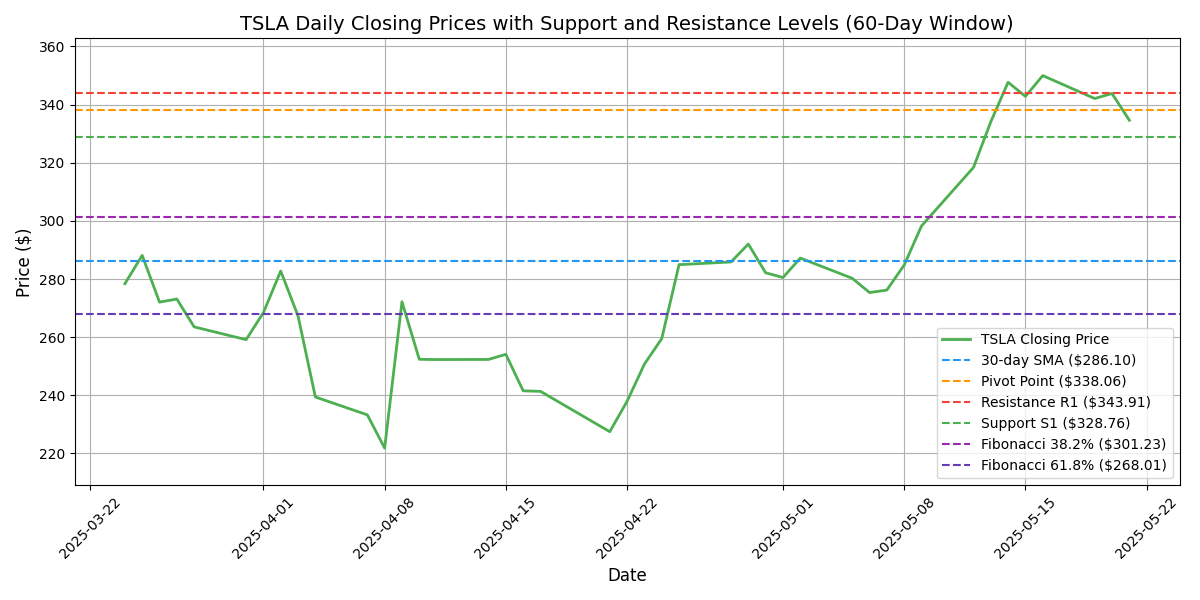

In [4]:
main(window_days=60)